# Problem 2

### Second order method

Consider the following Taylor Expansions:
$$ f(x+h) = f(x) + hf'(x) + \frac{h^2}{2}f''(x) + O(h^3)$$

$$ f(x-h) = f(x) - hf'(x) + \frac{h^2}{2}f''(x) + O(h^3)$$

From this, we obtain the following:

$$ \frac{f(x+h)-f(x-h)}{2h} = f'(x) + O(h^2) $$

So we conclude that the *central difference* $\frac{f(x+h)-f(x-h)}{2h}$ gives a higher order approximation than either the forward or backward difference.

In this method, if we take $h$ to be of the order $h \sim \sqrt[3]{\frac{6\epsilon}{f'''}}$ then the truncation and round-off errors balance. In this case, then we don't see the desired change in the errors as we scale $h$ in this order. This is shown below by choosing $h = \epsilon^{1/3}$ and then $h = 2\epsilon^{1/3}$

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def central_difference(f,x):
    xs = np.array(x)
    h = np.cbrt(np.finfo(type(x[0])).eps)
    df = f(x+h)-f(x-h)
    return (df/(2.0*h))

In [3]:
def central_difference1(f,x):
    xs = np.array(x)
    h = np.cbrt(np.finfo(type(x[0])).eps)*2.0
    df = f(x+h)-f(x-h)
    return (df/(2.0*h))

In [4]:
np.abs(cos(1.0)-central_difference(sin,[1.0]))

array([5.03619368e-12])

In [5]:
np.abs(cos(1.0)-central_difference1(sin,[1.0]))

array([1.42034162e-11])

As we see above, this does not give us the desired $h^2$ scaling. The regime we have taken for $h$ was too small so we now work with higher orders of magnitude.

In [6]:
np.cbrt(np.finfo(type(1.0)).eps)

6.0554544523933395e-06

We will take $h \sim 10^{-5}$ and higher.

In [7]:
def centralized_difference(f,x,h):
    xs = np.array(x)
    df = f(x+h)-f(x-h)
    return (df/(2.0*h))

In [8]:
hs = [1.25e-5,2.5e-5,5.0e-5,1.0e-4]
errors = [abs(cos(1.0)-centralized_difference(sin,1.0,hi)) for hi in hs]

Text(0.5, 1.0, 'Relative Error Scaling with $h$')

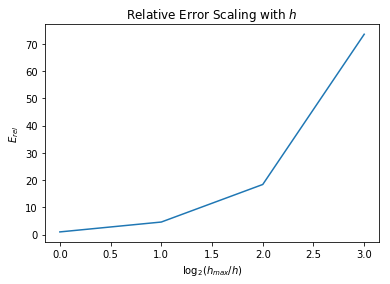

In [9]:
em = errors[0]
e_rel = [e/em for e in errors]
plot(e_rel)
xlabel('$\log_2(h_{max}/h)$')
ylabel('$E_{rel}$')
title('Relative Error Scaling with $h$')

From the plot above, we see that the function *centralized_difference()* does indeed obey the desired $h^2$ dependence. 

---
### Part b - Richardson Extrapolation

In order to perform the extrapolation to h=0, we want to fit a polynomial of order $N-1$, when we have taken $N$ different values of $h$. This gives us a system of linear equations for the coefficients.
$$
a_{n-1}h_{i}^{n-1} + a_{n-2}h_{i}^{n-2} + ... + a_1h_{i} + a_0 = c_{i}
$$

The $c_i$'s are the approximations given by the centralized difference formula. The system of equations can then be written as a matrix equation:
$$ Va = C $$

The matrix $V$, known as the Vandermode matrix contains powers of the different $h_i$'s chosen. As such, its rows and columns are linearly independent and thus V is not singular. The solution for the coefficients $a$ is then given by:
$$ a = V^{-1}C $$
$a_0$ then approximates the extrapolation to $h=0$.

In [10]:
def Richardson_Extrapolation(f,x,N):
    assert N>1
    h = 0.1
    Hs = [h/(2.0**i) for i in range(N)]
    approx = [centralized_difference(f,x,hi) for hi in Hs]
    #now we fit the approximations of the derivative to the hs with an N-1 order polynomial
    vander = [] #vandermode matrix
    for hh in Hs:
        v = [hh**i for i in range(N)]
        vander.append(v)
    extrapolates = np.dot(np.linalg.inv(vander),np.transpose(approx))
    return extrapolates[0]

In [11]:
abs(Richardson_Extrapolation(sin,1.0,3)-cos(1.0))

9.846015724956914e-08

In [12]:
abs(Richardson_Extrapolation(sin,1.0,4)-cos(1.0))

7.031129234391642e-09

In [13]:
abs(Richardson_Extrapolation(sin,1.0,5)-cos(1.0))

2.4713564528155985e-13

---
### Part c - Adaptive Extrapolation

In [14]:
def Richardson_Extrapolation_Adaptive(f,x,rtol=1.0e-12):
    Nmax = 10
    N = 2
    a0 = centralized_difference(f,x,0.05)
    a1 = Richardson_Extrapolation(f,x,N)
    while abs(a0-a1) >= rtol:
        N += 1
        if N > Nmax:
            print("Error: Desired Cenvergence Could Not Be Reached!")
            return a0
        else:
            a0 = a1
            a1 = Richardson_Extrapolation(f,x,N)
    return a0

In [15]:
abs(Richardson_Extrapolation_Adaptive(sin,1.0,1.0e-12)-cos(1.0))

2.4713564528155985e-13

So we see that the function *Richardson_Extrapolation_Adaptive* approximates the derivative of interest in the above case to part in $10^{-13}$ by dynamically picking how many step sizes to take.